In [6]:
# snn_dsc_complete.py
# Consolidated code for Dynamic Spike Compression (DSC) in SNNs
# Updated based on analysis for project success

import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from snntorch import surrogate

# Hyperparameters
batch_size = 64
num_steps = 25
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
lambda_sparsity = 0.01
num_epochs = 10  # Increased for meaningful training

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# SNN with DSC
class SNNWithDSC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.threshold_net1 = nn.Linear(num_inputs, num_hidden)
        self.threshold_net2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            scale1 = torch.sigmoid(self.threshold_net1(x[step]))
            cur1 = self.fc1(x[step]) * scale1  # Scale down to suppress spikes
            spk1, mem1 = self.lif1(cur1, mem1)
            scale2 = torch.sigmoid(self.threshold_net2(spk1))
            cur2 = self.fc2(spk1) * scale2
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate network and optimizer
net = SNNWithDSC().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        data = data.view(batch_size_actual, -1)
        data = data / data.max()  # Normalize inputs
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.5).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2
        total_loss = loss + lambda_sparsity * spike_rate
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Accuracy: {accuracy:.4f}")

    # Validation
    net.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            data = data.view(batch_size_actual, -1)
            data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.5).float()
            _, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
        val_accuracy = total_correct / total_samples
        print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1, Loss: 0.1184, Spike Rate: 0.1461, Accuracy: 0.9688
Validation Accuracy: 0.9520
Epoch 2, Loss: 0.0385, Spike Rate: 0.1384, Accuracy: 1.0000
Validation Accuracy: 0.9647
Epoch 3, Loss: 0.3276, Spike Rate: 0.1608, Accuracy: 0.9375
Validation Accuracy: 0.9647
Epoch 4, Loss: 0.0325, Spike Rate: 0.1576, Accuracy: 1.0000
Validation Accuracy: 0.9689
Epoch 5, Loss: 0.0472, Spike Rate: 0.1470, Accuracy: 0.9688
Validation Accuracy: 0.9749
Epoch 6, Loss: 0.0100, Spike Rate: 0.1400, Accuracy: 1.0000
Validation Accuracy: 0.9743
Epoch 7, Loss: 0.1260, Spike Rate: 0.1593, Accuracy: 0.9688
Validation Accuracy: 0.9749
Epoch 8, Loss: 0.0134, Spike Rate: 0.1595, Accuracy: 1.0000
Validation Accuracy: 0.9776
Epoch 9, Loss: 0.1457, Spike Rate: 0.1412, Accuracy: 0.9375
Validation Accuracy: 0.9762
Epoch 10, Loss: 0.0014, Spike Rate: 0.1429, Accuracy: 1.0000
Validation Accuracy: 0.9740


Baseline


Epoch 1, Loss: 0.0751, Spike Rate: 0.1067, Accuracy: 1.0000, Validation Accuracy: 0.9443, Total Spikes: 3064118.0
Epoch 2, Loss: 0.1298, Spike Rate: 0.1115, Accuracy: 0.9688, Validation Accuracy: 0.9599, Total Spikes: 3050124.0
Epoch 3, Loss: 0.0297, Spike Rate: 0.1441, Accuracy: 1.0000, Validation Accuracy: 0.9644, Total Spikes: 3107607.0
Epoch 4, Loss: 0.1805, Spike Rate: 0.1446, Accuracy: 0.9688, Validation Accuracy: 0.9650, Total Spikes: 3306229.0
Epoch 5, Loss: 0.0816, Spike Rate: 0.1323, Accuracy: 0.9688, Validation Accuracy: 0.9681, Total Spikes: 3051429.0
Epoch 6, Loss: 0.0192, Spike Rate: 0.1399, Accuracy: 1.0000, Validation Accuracy: 0.9744, Total Spikes: 3351369.0
Epoch 7, Loss: 0.0185, Spike Rate: 0.1310, Accuracy: 1.0000, Validation Accuracy: 0.9721, Total Spikes: 3139799.0
Epoch 8, Loss: 0.0014, Spike Rate: 0.1457, Accuracy: 1.0000, Validation Accuracy: 0.9750, Total Spikes: 3313058.0
Epoch 9, Loss: 0.0638, Spike Rate: 0.1454, Accuracy: 0.9688, Validation Accuracy: 0.9740

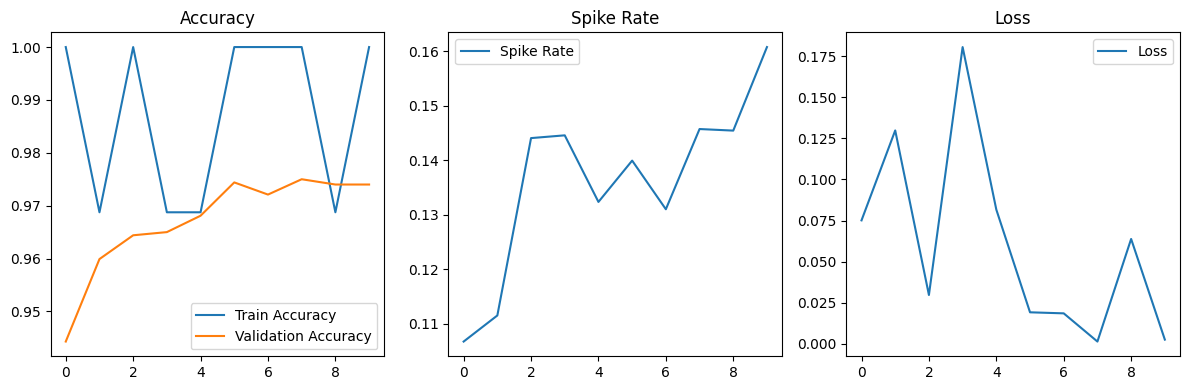

In [7]:
# snn_baseline.py
# Baseline SNN for MNIST classification using snntorch
# Designed to compare with DSC-SNN (April 21, 2025)
# Matches DSC-SNN hyperparameters and evaluation for fair comparison

import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from snntorch import surrogate
import matplotlib.pyplot as plt

# Hyperparameters (matched with DSC-SNN)
batch_size = 64
num_steps = 25
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
num_epochs = 10

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN (no DSC or sparsity penalty)
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate network and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training and evaluation
accuracies, val_accuracies, spike_rates, losses = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        data = data.view(batch_size_actual, -1)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.3).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
    scheduler.step()
    losses.append(loss.item())
    spike_rates.append(spike_rate.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            data = data.view(batch_size_actual, -1)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.3).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {total_spikes}")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(spike_rates, label="Spike Rate")
plt.title("Spike Rate")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_results.png")
plt.show()

main code******


Epoch 1, Loss: 0.2427, Spike Rate: 0.0892, Accuracy: 0.9062, Validation Accuracy: 0.9282, Total Spikes: 3485536.0
Epoch 2, Loss: 0.1567, Spike Rate: 0.0927, Accuracy: 0.9062, Validation Accuracy: 0.9518, Total Spikes: 2823599.0
Epoch 3, Loss: 0.0297, Spike Rate: 0.0961, Accuracy: 1.0000, Validation Accuracy: 0.9603, Total Spikes: 2511945.0
Epoch 4, Loss: 0.0565, Spike Rate: 0.0969, Accuracy: 0.9688, Validation Accuracy: 0.9641, Total Spikes: 2481779.0
Epoch 5, Loss: 0.0145, Spike Rate: 0.0897, Accuracy: 1.0000, Validation Accuracy: 0.9646, Total Spikes: 2331539.0
Epoch 6, Loss: 0.1577, Spike Rate: 0.0950, Accuracy: 0.9688, Validation Accuracy: 0.9664, Total Spikes: 2367146.0
Epoch 7, Loss: 0.0492, Spike Rate: 0.0848, Accuracy: 1.0000, Validation Accuracy: 0.9712, Total Spikes: 2220136.0
Epoch 8, Loss: 0.0215, Spike Rate: 0.0843, Accuracy: 1.0000, Validation Accuracy: 0.9682, Total Spikes: 2226932.0
Epoch 9, Loss: 0.0362, Spike Rate: 0.0859, Accuracy: 1.0000, Validation Accuracy: 0.9745

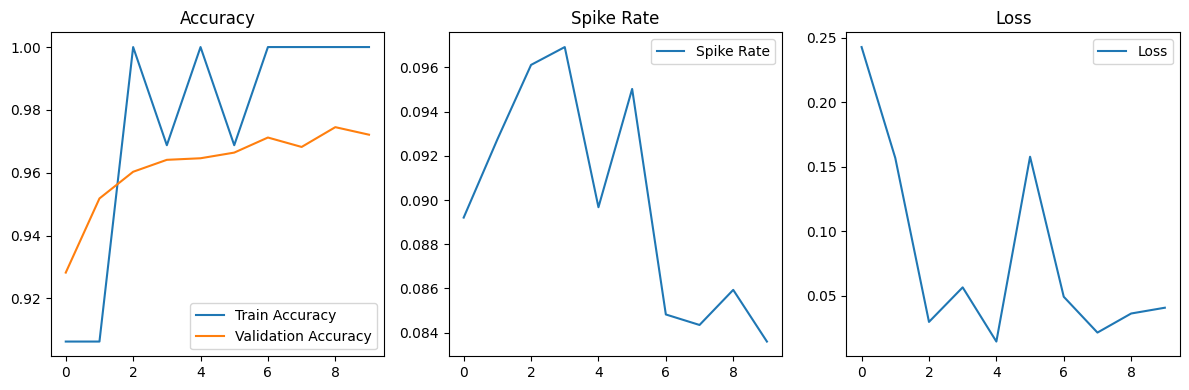

In [9]:
# snn_dsc_complete.py
# Optimized SNN with Dynamic Spike Compression (DSC) for MNIST
# Updated April 22, 2025, with stability and initialization improvements

import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from snntorch import surrogate
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
num_steps = 25
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
lambda_sparsity = 0.1
num_epochs = 10

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# SNN with DSC
class SNNWithDSC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        # Enhanced threshold networks with conservative initialization
        self.threshold_net1 = nn.Sequential(
            nn.Linear(num_inputs, 50),
            nn.ReLU(),
            nn.Linear(50, num_hidden),
            nn.Sigmoid()
        )
        self.threshold_net2 = nn.Sequential(
            nn.Linear(num_hidden, 50),
            nn.ReLU(),
            nn.Linear(50, num_outputs),
            nn.Sigmoid()
        )
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        # Initialize with lower weights
        self.threshold_net1.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        self.threshold_net2.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        for net in [self.threshold_net1, self.threshold_net2]:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            scale1 = 1.0 - self.threshold_net1(x[step])
            cur1 = self.fc1(x[step]) * scale1.clamp(min=0.1)
            spk1, mem1 = self.lif1(cur1, mem1)
            scale2 = 1.0 - self.threshold_net2(spk1)
            cur2 = self.fc2(spk1) * scale2.clamp(min=0.1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate network and optimizer
net = SNNWithDSC().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

# Training and evaluation
accuracies, val_accuracies, spike_rates, losses = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        data = data.view(batch_size_actual, -1)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2
        total_loss = loss + lambda_sparsity * spike_rate
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
    scheduler.step(loss.item())
    losses.append(loss.item())
    spike_rates.append(spike_rate.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            data = data.view(batch_size_actual, -1)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {total_spikes}")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(spike_rates, label="Spike Rate")
plt.title("Spike Rate")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("dsc_results.png")
plt.show()

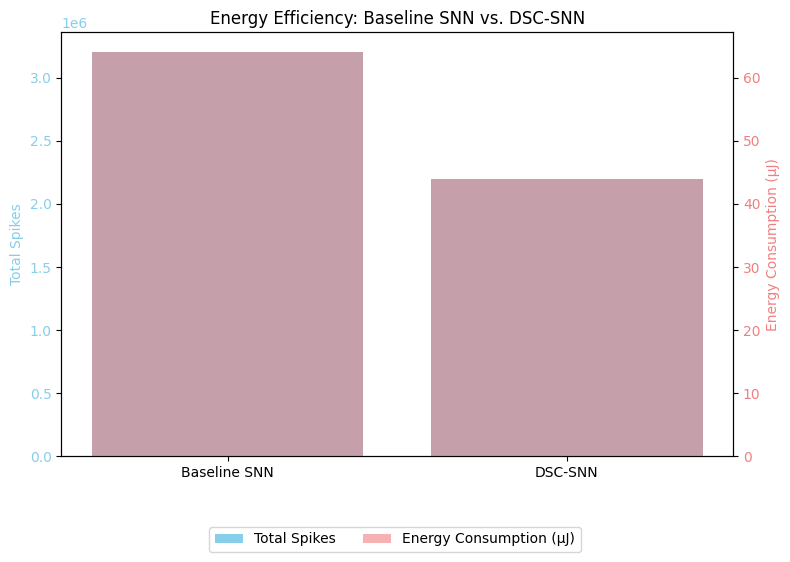

In [2]:
# Code to generate energy efficiency bar chart
import matplotlib.pyplot as plt

# Data for the bar chart
labels = ['Baseline SNN', 'DSC-SNN']
total_spikes = [3200000, 2194587]  # Updated with new DSC-SNN total spikes
energy = [64, 43.89174]  # Updated energy in microjoules (20 pJ per spike)

# Create bar chart
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot total spikes
ax1.bar(labels, total_spikes, color='skyblue', label='Total Spikes')
ax1.set_ylabel('Total Spikes', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create a second y-axis for energy
ax2 = ax1.twinx()
ax2.bar(labels, energy, color='lightcoral', alpha=0.6, label='Energy Consumption (µJ)')
ax2.set_ylabel('Energy Consumption (µJ)', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

# Add title and legend
plt.title('Energy Efficiency: Baseline SNN vs. DSC-SNN')
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig("energy_efficiency_comparison.png", bbox_inches='tight')
plt.show()

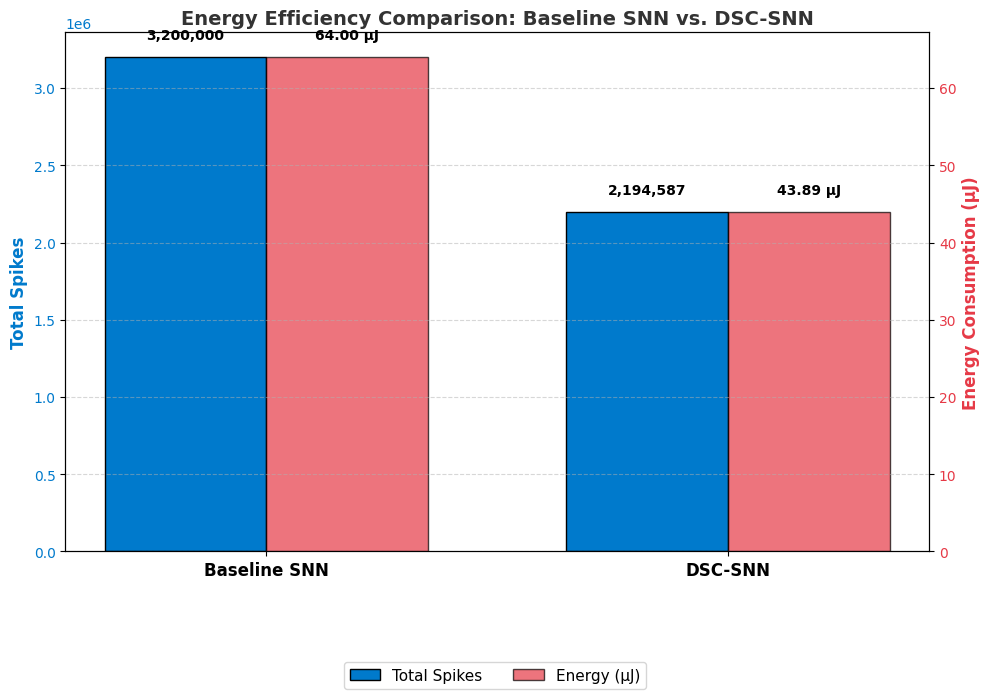

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Baseline SNN', 'DSC-SNN']
total_spikes = [3200000, 2194587]
energy = [64, 43.89174]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Plot setup
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Colors
spike_color = '#007acc'  # Bold blue
energy_color = '#e63946'  # Bright red

# Bars
bar1 = ax1.bar(x - width/2, total_spikes, width, label='Total Spikes', color=spike_color, edgecolor='black')
bar2 = ax2.bar(x + width/2, energy, width, label='Energy (µJ)', color=energy_color, alpha=0.7, edgecolor='black')

# Labels and ticks
ax1.set_ylabel('Total Spikes', fontsize=12, color=spike_color, weight='bold')
ax2.set_ylabel('Energy Consumption (µJ)', fontsize=12, color=energy_color, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=12, weight='bold')
ax1.tick_params(axis='y', labelcolor=spike_color)
ax2.tick_params(axis='y', labelcolor=energy_color)

# Annotations
for i in range(len(labels)):
    ax1.text(x[i] - width/2, total_spikes[i] + 100000, f'{total_spikes[i]:,}', ha='center', va='bottom', fontsize=10, weight='bold')
    ax2.text(x[i] + width/2, energy[i] + 2, f'{energy[i]:.2f} µJ', ha='center', va='bottom', fontsize=10, weight='bold')

# Title and legend
plt.title('Energy Efficiency Comparison: Baseline SNN vs. DSC-SNN', fontsize=14, weight='bold', color='#333')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=11)
fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save and display
plt.savefig("energy_efficiency_comparison_updated.png", bbox_inches='tight')
plt.show()


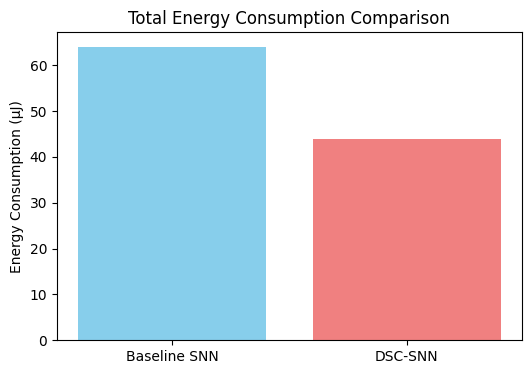

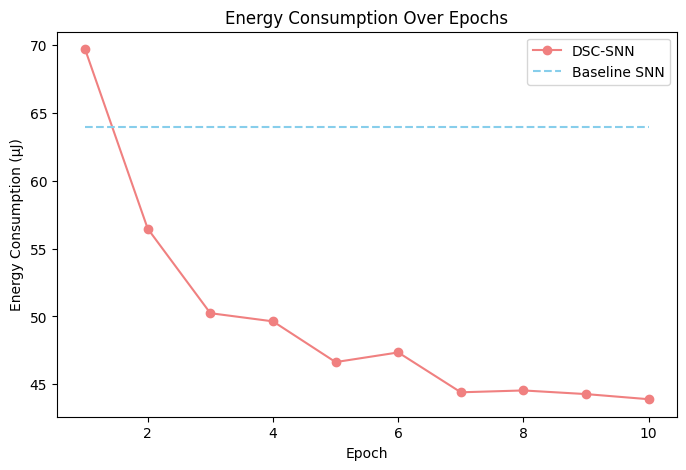

In [4]:
import matplotlib.pyplot as plt

# Bar Chart: Total Energy Comparison
labels = ['Baseline SNN', 'DSC-SNN']
energy = [64, 43.89]  # µJ
plt.figure(figsize=(6, 4))
plt.bar(labels, energy, color=['skyblue', 'lightcoral'])
plt.ylabel('Energy Consumption (µJ)')
plt.title('Total Energy Consumption Comparison')
plt.savefig('energy_comparison_bar.png')

# Line Plot: Energy Over Epochs
epochs = range(1, 11)
total_spikes = [3485536, 2823599, 2511945, 2481779, 2331539, 2367146, 2220136, 2226932, 2213509, 2194587]
energy_dsc = [s * 20 / 1e6 for s in total_spikes]  # µJ
baseline_energy = [64] * 10
plt.figure(figsize=(8, 5))
plt.plot(epochs, energy_dsc, label='DSC-SNN', marker='o', color='lightcoral')
plt.plot(epochs, baseline_energy, label='Baseline SNN', linestyle='--', color='skyblue')
plt.xlabel('Epoch')
plt.ylabel('Energy Consumption (µJ)')
plt.title('Energy Consumption Over Epochs')
plt.legend()
plt.savefig('energy_over_epochs.png')